In [52]:
## Codigo basado en el trabajo de https://medium.com/@writingforara/solving-vehicle-routing-problems-with-python-heuristics-algorithm-2cc57fe7079c
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np

random.seed(42)
np.random.seed(42)

In [53]:
def read_data(filename):
    """
    Read coordinates and demand values from a specific sheet in an Excel file.
    Assumes the data is in columns labeled 'X', 'Y', and 'Demand'.
    """
    df_grl = pd.read_excel(filename, sheet_name='GRL') #N	H	CP
    df_locales = pd.read_excel(filename, sheet_name='RTL') #i	X	Y	I	U	L	r	h

    ubicaciones = df_locales[['X', 'Y']].values 
    ubis = [list(ubicaciones[i]) for i in range(len(ubicaciones))]
    # info_locales = df_locales[['i','I','U','L','r','h']].values
    cap_tpte = df_grl['CP'].values[0]

    # return df_locales
    return ubis, cap_tpte, df_locales

# read_excel_file('IRP1.xlsx', 'GRL')
ubis, cap_tpte, info_locales = read_data('IRP1.xlsx') #i	X	Y	I	U	L	r	h


In [54]:
info_locales

,i,X,Y,I,U,L,r,h
0,0,444,237,1428,NaN,0,-581,0.30
1,1,152,180,87,174.0,0,87,0.23
2,2,230,141,27,54.0,0,27,0.32
3,3,134,163,20,30.0,0,10,0.33
4,4,459,282,55,110.0,0,55,0.23
5,5,269,455,142,213.0,0,71,0.18
6,6,79,326,69,138.0,0,69,0.29
7,7,5,235,158,237.0,0,79,0.42
8,8,51,412,86,129.0,0,43,0.42
9,9,310,113,77,154.0,0,77,0.24


In [140]:
def calcular_distancia(n1, n2):

    x1, y1 = n1[0], n1[1]
    x2, y2 = n2[0], n2[1]

    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def calcular_matriz_dist(G):
    matriz_distancias = {nodo: {} for nodo in G.nodes()}
    for arco in G.edges(data=True):
        n1, n2, data = arco
        matriz_distancias[n1][n2] = data['weight']

    for n1 in G.nodes():
        for n2 in G.nodes():
            if n2 not in matriz_distancias[n1].keys():
                matriz_distancias[n1][n2] = np.inf


def calcular_largo_ruta(ruta, matriz_dist):
    """
    Calculate the total distance of a given ruta using the distance matrix.
    """
    sum_dist = 0
    num_puntos = len(ruta)

    for i in range(num_puntos - 1):
        nodo = ruta[i]
        next_nodo = ruta[i + 1]
        sum_dist += matriz_dist[nodo, next_nodo]

    return sum_dist


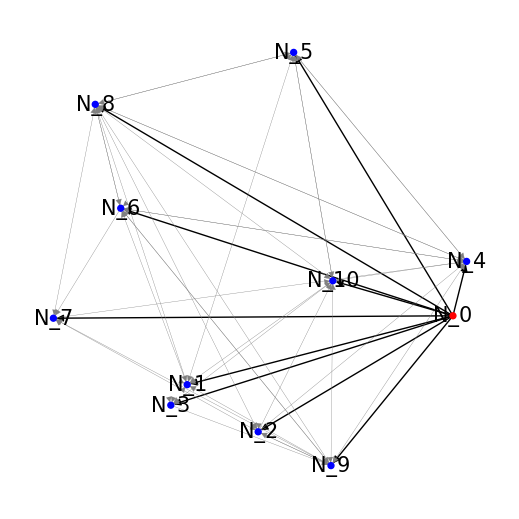

In [148]:
G = nx.DiGraph()
color_nodos = []
color_arcos = []
ancho_edges = []

for local in info_locales.itertuples():
    # print(local.i)
    G.add_node(f"N_{local.i}", Inv = local.I, Up = local.U, Low = local.L, Prod = local.r, h = local.h,
        coord_x = local.X, coord_y = local.Y, pos = (local.X, local.Y))
    if local.i != 0:
        color_nodos.append('blue') 
    else:
        color_nodos.append('red')

e=0
for local in G.nodes():
    for nodo in G.nodes():
        if local != nodo:
            decision = np.random.binomial(1, 0.7)
            if decision == 1 and local != 'N_0' and nodo != 'N_0':
                dist = calcular_distancia(G.nodes[local]['pos'], G.nodes[nodo]['pos'])
                G.add_edge(local, nodo, weight=dist)
                e +=1
                # ancho_edges.append(dist/1000)
                ancho_edges.append(0.25)
                color_arcos.append('gray')
            elif local == 'N_0':
                dist = calcular_distancia(G.nodes[local]['pos'], G.nodes[nodo]['pos'])
                G.add_edge(local, nodo, weight=dist)
                e +=1
                ancho_edges.append(1)
                color_arcos.append('black')
            else:
                ancho_edges.append(0)
    
#     for j in range(len(ubis)):
#         if i != j:
#             decision = np.random.binomial(1, 0.7)
#             if decision == 1:
#                 print(i, j)
#                 G.add_edge(i, j, weight=random.randint(1, 10))

plt.figure(figsize=(5,5))
# nx.draw(G, with_labels=True, node_size=18, node_color=color_nodos, font_size=15, edge_color=ancho_edges, width=ancho_edges, edge_cmap=plt.cm.Greys)
pos=nx.get_node_attributes(G,'pos')
nx.draw(G, pos=pos, with_labels=True, node_size=18, font_size=15, node_color=color_nodos, width=ancho_edges, edge_color=color_arcos)
plt.show()

In [160]:
# calculate_distance_matrix(G)
matriz_distancias = {nodo: {} for nodo in G.nodes()}
for arco in G.edges(data=True):
    n1, n2, data = arco
    matriz_distancias[n1][n2] = data['weight']

for n1 in G.nodes():
    for n2 in G.nodes():
        if n2 not in matriz_distancias[n1].keys():
            matriz_distancias[n1][n2] = np.inf
matriz_distancias

{'N_0': {'N_1': 297.5113443215233,
  'N_2': 234.54637068179076,
  'N_3': 318.709899438345,
  'N_4': 47.43416490252569,
  'N_5': 279.5514263959317,
  'N_6': 375.69402444010205,
  'N_7': 439.00455578501686,
  'N_8': 430.20227800419656,
  'N_9': 182.5705343148231,
  'N_10': 135.14806694880988,
  'N_0': inf},
 'N_1': {'N_2': 87.20665112249179,
  'N_6': 163.23296235748464,
  'N_7': 156.95222202950808,
  'N_9': 171.618763542918,
  'N_10': 181.64801127455263,
  'N_0': inf,
  'N_1': inf,
  'N_3': inf,
  'N_4': inf,
  'N_5': inf,
  'N_8': inf},
 'N_2': {'N_4': 268.9274995235705,
  'N_7': 243.8462630429263,
  'N_8': 324.7799254880141,
  'N_9': 84.75848040166836,
  'N_10': 149.4958193395387,
  'N_0': inf,
  'N_1': inf,
  'N_2': inf,
  'N_3': inf,
  'N_5': inf,
  'N_6': inf},
 'N_3': {'N_1': 24.758836806279895,
  'N_5': 321.69706246716026,
  'N_7': 147.73286702694156,
  'N_9': 182.96447742663054,
  'N_0': inf,
  'N_2': inf,
  'N_3': inf,
  'N_4': inf,
  'N_6': inf,
  'N_8': inf,
  'N_10': inf},
 '

In [ ]:
def nearest_neighbor(dist_matrix, demands, capacity):
    """
    Apply the Nearest Neighbor heuristic to find initial routes for VRP.
    """
    num_points = dist_matrix.shape[0]
    visited = np.zeros(num_points, dtype=bool)
    routes = []

    while np.sum(visited) < num_points:
        current_node = 0  # Start at node 0
        current_capacity = 0
        route = [current_node]
        visited[current_node] = True

        while current_capacity + demands[current_node] <= capacity:
            current = route[-1]
            nearest = None
            min_dist = float('inf')

            for neighbor in np.where(~visited)[0]:
                if demands[neighbor] + current_capacity <= capacity and dist_matrix[current, neighbor] < min_dist:
                    nearest = neighbor
                    min_dist = dist_matrix[current, neighbor]

            if nearest is None:
                break

            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]

        routes.append(route)

    return routes


def format_output(routes):
    """
    Format the final routes as required.
    In this example, it returns a list of routes.
    """
    return routes


def vrp_solver(filename, sheet_name, capacity):
    """
    Solve the VRP using the provided filename for coordinates and vehicle capacity.
    """
    coordinates, demands = read_excel_file(filename, sheet_name)
    dist_matrix = calculate_distance_matrix(coordinates)
    routes = nearest_neighbor(dist_matrix, demands, capacity)
    formatted_routes = format_output(routes)
    return formatted_routes

#Use nearest neighbor
filename = r"C:\Users\Firdaus\Documents\DATA VRP ASSIGNMENT.xlsx" #Copy file path
sheet_name = "vrp 45"  # Specify the name of the sheet or its index
capacity = 2010 # Specify the capacity of the vehicle
solution = vrp_solver(filename, sheet_name, capacity)

for route in solution:
    print(route)

In [ ]:
def two_opt(routes, dist_matrix, num_iterations):
    best_routes = routes.copy()

    for _ in range(num_iterations):
        selected_route_idx = np.random.randint(0, len(routes))
        selected_route = routes[selected_route_idx]

        i, j = np.random.randint(1, len(selected_route) - 1, size=2)
        if j < i:
            i, j = j, i

        new_route = selected_route.copy()
        new_route[i:j] = selected_route[j - 1: i - 1: -1]  # Reverse the path between i and j

        new_routes = routes.copy()
        new_routes[selected_route_idx] = new_route

        if calculate_total_distance(new_routes[selected_route_idx], dist_matrix) < calculate_total_distance(
                best_routes[selected_route_idx], dist_matrix
        ):
            best_routes = new_routes

    return best_routes

def vrp_solver2(filename, sheet_name, capacity, num_iterations):
    """
    Solve the VRP using the provided filename for coordinates, vehicle capacity,
    and number of iterations for the two-opt optimization.
    """
    coordinates, demands = read_excel_file(filename, sheet_name)
    dist_matrix = calculate_distance_matrix(coordinates)
    routes = nearest_neighbor(dist_matrix, demands, capacity)

    for i in range(len(routes)):
        route = routes[i]
        optimized_route = two_opt([route], dist_matrix, num_iterations)[0]
        routes[i] = optimized_route

    formatted_routes = format_output(routes)
    return formatted_routes

filename = r"C:\Users\Firdaus\Documents\DATA VRP ASSIGNMENT.xlsx"
sheet_name = "vrp 421"  # Specify the name of the sheet or its index
capacity = 200 # Specify the capacity of the vehicle
num_iterations = 100000
solution=vrp_solver2(filename, sheet_name, capacity, num_iterations)
print(solution)

for route in solution:
-    print(route)

In [ ]:
def simple_forecaster(x):
    list_x = list(x)
    average = np.mean(list_x)
    return average

In [1]:
from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxRuntime

In [ ]:
T = 100 # periodos
V = 10 # vertices
def proactive_routing_only():
    '''
    pseudocode

    1: for t=0 to p-11 do
    2:  for i=1 to n do
    3:      Computean f-period forecastfor i based onpast
            demand observations.
    4:  end for
    5:  ApplytheALNS-basedheuristictothereduced f-period
    problem.
    6:  Implementtherouteobtainedforthe first period.
    7: end for
    '''
    for t in range(T):
        for i in range(1, V):
            d = simple_forecaster(x)
            pass
        
        # 5:  ApplytheALNS-basedheuristictothereduced f-period
        # problem.
        # 6:  Implementtherouteobtainedforthe first period.
        pass
    
    